# Basic Demo Workflow

**Author:** [Severin Dicks](https://github.com/Intron7)
**Copyright** [scverse](https://scverse.org)

In this notebook, we demonstrate the **GPU-acceleration capabilities** of **rapids-SingleCell** for efficient single-cell analysis.  
This tutorial showcases how to leverage **GPU computing** to significantly speed up your analysis workflow.

This method makes **high-performance single-cell analysis accessible** through straightforward GPU integration,
transforming traditionally time-consuming analyses into rapid workflows.

In [1]:
import scanpy as sc
import cupy as cp

import time
import rapids_singlecell as rsc

import warnings

warnings.filterwarnings("ignore")

In [2]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator

rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=False,  # default is False
    devices=0,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 

In [3]:
data_load_start = time.time()

In [4]:
%%time
adata = sc.read("h5/dli_census.h5ad")

CPU times: user 344 ms, sys: 1.37 s, total: 1.71 s
Wall time: 1.71 s


In [5]:
%%time
rsc.get.anndata_to_GPU(adata)

CPU times: user 152 ms, sys: 2.2 s, total: 2.35 s
Wall time: 2.35 s


In [6]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time - data_load_start))

Total data load and format time: 4.077548503875732


## Preprocessing

In [7]:
preprocess_start = time.time()

In [8]:
adata.var_names = adata.var.feature_name

### Quality Control

We calculate quality control (QC) metrics to assess cell and gene quality. These include:  

- **Per cell metrics**:  
  - Total counts per cell (library size)  
  - Number of detected genes per cell  
  - Percentage of counts from mitochondrial (`MT`) and ribosomal (`RIBO`) genes  

- **Per gene metrics** (gene space):  
  - Total counts per gene  
  - Number of cells expressing each gene  

These metrics help identify low-quality or stressed cells and ensure a meaningful feature set for downstream analysis.

In [9]:
%%time
rsc.pp.flag_gene_family(adata, gene_family_name="MT", gene_family_prefix="MT")

CPU times: user 6.75 ms, sys: 0 ns, total: 6.75 ms
Wall time: 6.71 ms


In [10]:
%%time
rsc.pp.flag_gene_family(adata, gene_family_name="RIBO", gene_family_prefix="RPS")

CPU times: user 6.3 ms, sys: 0 ns, total: 6.3 ms
Wall time: 6.22 ms


In [11]:
%%time
rsc.pp.calculate_qc_metrics(adata, qc_vars=["MT", "RIBO"])

CPU times: user 66.7 ms, sys: 7.9 ms, total: 74.6 ms
Wall time: 74.4 ms


To visualize the quality control (QC) metrics, we generate the following plots:

1. **Scatter plot: Total counts vs. Mitochondrial percentage**  
   - This plot shows the relationship between the total UMI counts per cell and the percentage of mitochondrial (`MT`) gene expression.  
   - Cells with high mitochondrial percentages may indicate stressed or dying cells.

2. **Scatter plot: Total counts vs. Number of detected genes**  
   - This plot displays the correlation between the total UMI counts per cell and the number of detected genes.  
   - A strong correlation is expected, but outliers with low gene counts might indicate empty droplets or dead cells.

3. **Violin plot: Number of detected genes per cell**  
   - This violin plot visualizes the distribution of the number of detected genes per cell.  
   - It helps identify cells with abnormally low or high gene counts, which could be filtered out.

4. **Violin plot: Total counts per cell**  
   - This plot shows the distribution of total counts per cell, indicating library size variation.  
   - Extreme values may suggest low-quality or overly dominant cells.

5. **Violin plot: Percentage of mitochondrial counts per cell**  
   - This plot illustrates the distribution of mitochondrial gene expression across all cells.  
   - High mitochondrial content could be a sign of cell stress or apoptosis.

These visualizations help assess dataset quality and guide decisions on filtering low-quality cells.

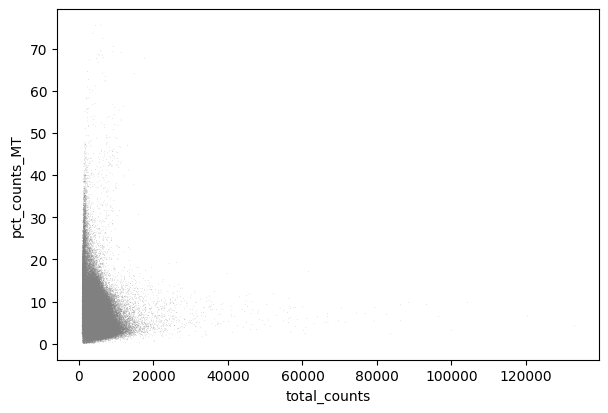

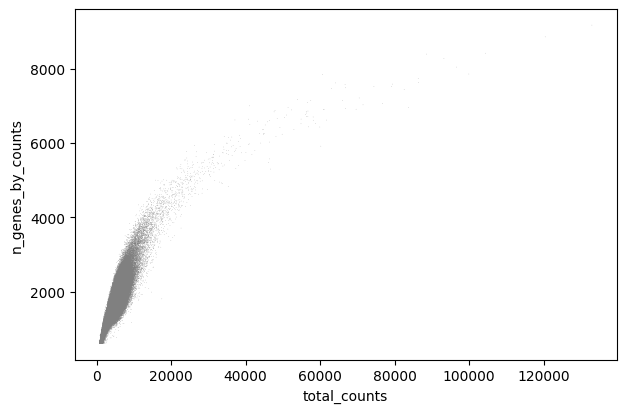

In [12]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_MT")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

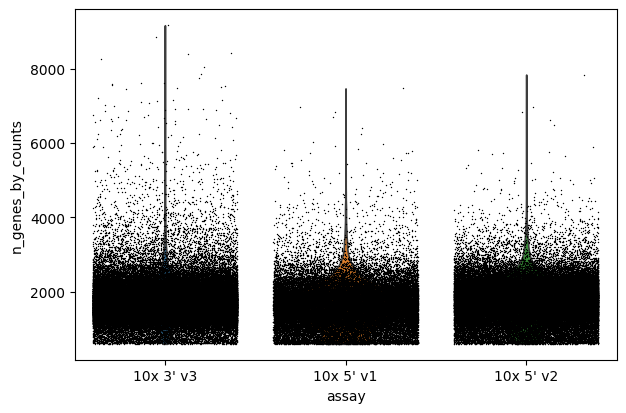

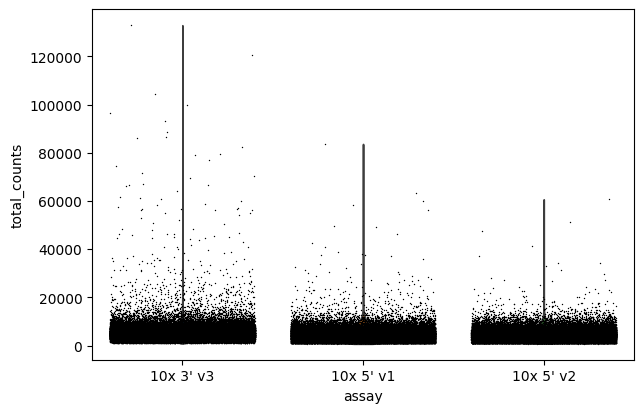

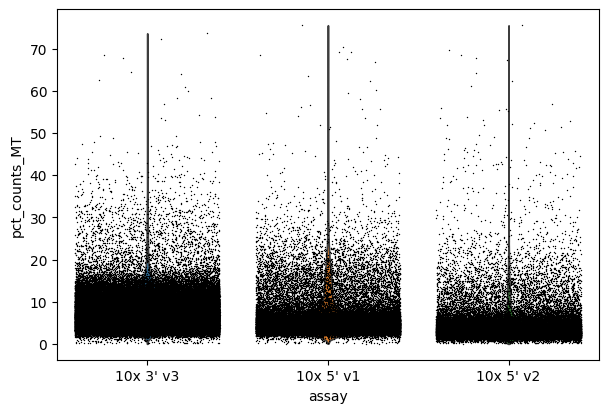

In [13]:
sc.pl.violin(adata, "n_genes_by_counts", jitter=0.4, groupby="assay")
sc.pl.violin(adata, "total_counts", jitter=0.4, groupby="assay")
sc.pl.violin(adata, "pct_counts_MT", jitter=0.4, groupby="assay")

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.
We also filter out cells with a mitchondrial countent of more than 20%.

In [14]:
%%time
adata = adata[adata.obs["n_genes_by_counts"] < 5000]
adata = adata[adata.obs["pct_counts_MT"] < 20]

CPU times: user 125 ms, sys: 16.1 ms, total: 141 ms
Wall time: 141 ms


We also filter out genes that are expressed in less than 3 cells.

In [15]:
%%time
rsc.pp.filter_genes(adata, min_cells=3)

filtered out 33823 genes that are detected in less than 3 cells
CPU times: user 411 ms, sys: 108 ms, total: 519 ms
Wall time: 749 ms


The size of our count matrix is now reduced.

In [16]:
adata.shape

(213082, 28065)

### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [17]:
%%time
rsc.pp.normalize_total(adata, target_sum=1e4)

CPU times: user 744 μs, sys: 86 μs, total: 830 μs
Wall time: 682 μs


Next, we data transform the count matrix.

In [18]:
%%time
rsc.pp.log1p(adata)

CPU times: user 9.37 ms, sys: 20.4 ms, total: 29.7 ms
Wall time: 92.2 ms


### Select Most Variable Genes

We now search for highly variable genes. This function supports the flavors `cell_ranger`, `seurat`, `seurat_v3`, and `pearson_residuals`.  
As in Scanpy, you can either filter based on variance cutoffs or select the `n_top_genes`. Additionally, you can use a `batch_key` to correct for batch effects.  

In this example, we use the `cell_ranger` method, which selects highly variable genes based on the log-normalized counts stored in `.X`.


In [19]:
%%time
rsc.pp.highly_variable_genes(adata, n_top_genes=5000, flavor="cell_ranger")

CPU times: user 204 ms, sys: 16.2 ms, total: 220 ms
Wall time: 218 ms


Now we safe this version of the AnnData as adata.raw. 

In [20]:
%%time
adata.raw = adata

CPU times: user 231 ms, sys: 146 ms, total: 377 ms
Wall time: 376 ms


We now restrict our AnnData object to only the highly variable genes.  
This step reduces the number of features, focusing the analysis on the most informative genes while improving computational efficiency.

In [21]:
%%time
rsc.pp.filter_highly_variable(adata)

CPU times: user 493 ms, sys: 318 ms, total: 811 ms
Wall time: 810 ms


Next, we regress out the effects of total counts per cell and mitochondrial content.  
This helps remove technical variation that could bias downstream analyses.  

As in Scanpy, you can regress out any numerical column from `.obs`, allowing for the correction of batch effects, sequencing depth, or other confounding factors.

In [22]:
%%time
rsc.pp.regress_out(adata, keys=["total_counts", "pct_counts_MT"])

CPU times: user 702 ms, sys: 808 ms, total: 1.51 s
Wall time: 1.51 s


### Scale

Finally, we scale the count matrix to obtain a z-score transformation, standardizing gene expression across cells.  
To prevent extreme values from dominating the analysis, we apply a cutoff of 10 standard deviations.  
This ensures that highly expressed genes do not disproportionately influence downstream computations.

In [23]:
%%time
rsc.pp.scale(adata, max_value=10)

CPU times: user 58.9 ms, sys: 852 μs, total: 59.8 ms
Wall time: 59.1 ms


Now we move `.X` out of the GPU.

In [24]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time - preprocess_start))

Total Preprocessing time: 8.972412824630737


## Clustering and Visualization

### Principal component analysis

We use Principal Component Analysis (PCA) to reduce the dimensionality of the gene expression matrix to its top 100 principal components.  
This step captures the most important sources of variation in the data while reducing computational complexity.  

We use the GPU-accelerated PCA implementation from cuML, which significantly speeds up computation compared to CPU-based methods.

In [25]:
%%time
rsc.tl.pca(adata, n_comps=100)

CPU times: user 1.26 s, sys: 145 ms, total: 1.4 s
Wall time: 1.61 s


We can use scanpy `pca_variance_ratio` plot to inspect the contribution of single PCs to the total variance in the data.

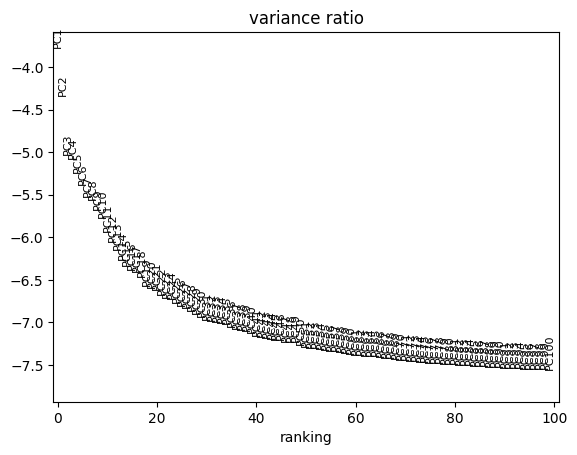

In [26]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=100)

Now, we transfer the `.X` matrix back to host (CPU) memory to free up GPU resources.  

Since some downstream analyses or visualizations may not require GPU acceleration, this step helps optimize memory usage,  
preventing unnecessary GPU load while still keeping the processed data accessible for further analysis.

In [27]:
rsc.get.anndata_to_CPU(adata)

### Computing the neighborhood graph and UMAP

Next, we compute the neighborhood graph using `rsc`.  

Scanpy’s CPU-based implementation of nearest neighbor search uses an approximation, while the GPU-accelerated RAPIDS implementation computes the exact graph.  
Both methods are valid, but small differences in results can occur.  

The following approximate nearest neighbor (ANN) algorithms are also supported:  
- **`ivfflat`**: Uses an inverted file index for fast approximate search, suitable for very large datasets.  
- **`ivfpq`**: A variant of `ivfflat` that compresses data for even more efficient memory usage, trading off some accuracy.  
- **`cagra`**: A graph-based ANN method optimized for fast, high-accuracy queries on GPUs.  
- **`nn_descent`**: A graph-based method that incrementally refines the nearest neighbor search and works well for large, high-dimensional datasets.  

Since our dataset is relatively small, we use **brute-force (`brute`)** search to ensure exact results.

In [28]:
%%time
rsc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)

CPU times: user 1.15 s, sys: 148 ms, total: 1.3 s
Wall time: 1.29 s


Next, we calculate the UMAP embedding using RAPIDS.  

UMAP (Uniform Manifold Approximation and Projection) is a dimensionality reduction technique that preserves local and global structure in the data.  
The RAPIDS implementation accelerates UMAP computation on GPUs, making it significantly faster than the standard CPU version.

In [29]:
%%time
rsc.tl.umap(adata)

CPU times: user 287 ms, sys: 77.1 ms, total: 364 ms
Wall time: 362 ms


### Clustering

Next, we use the **Louvain** and **Leiden** algorithms for graph-based clustering with RAPIDS.  

Both methods detect communities (clusters) in the neighborhood graph by optimizing modularity:  
- **Louvain**: A hierarchical clustering algorithm that iteratively refines clusters for optimal modularity.  
- **Leiden**: An improved version of Louvain that guarantees well-connected, more stable clusters.  

Using RAPIDS accelerates the clustering process on GPUs, making it significantly faster than traditional CPU implementations.

In [30]:
%%time
rsc.tl.louvain(adata, resolution=0.6)

CPU times: user 919 ms, sys: 1.24 s, total: 2.16 s
Wall time: 2.15 s


In [31]:
%%time
rsc.tl.leiden(adata, resolution=0.6)

CPU times: user 697 ms, sys: 1.13 s, total: 1.83 s
Wall time: 1.82 s


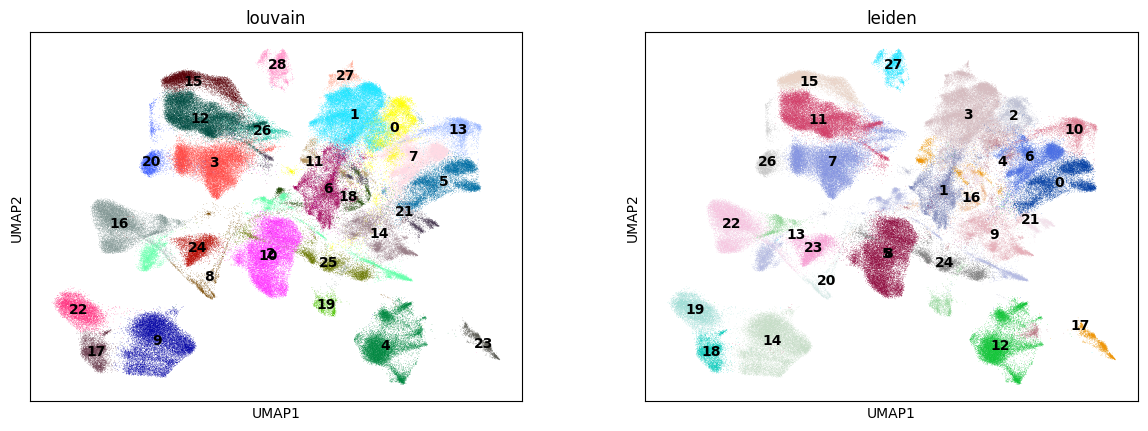

CPU times: user 1.37 s, sys: 17.7 ms, total: 1.39 s
Wall time: 1.38 s


In [32]:
%%time
sc.pl.umap(adata, color=["louvain", "leiden"], legend_loc="on data")

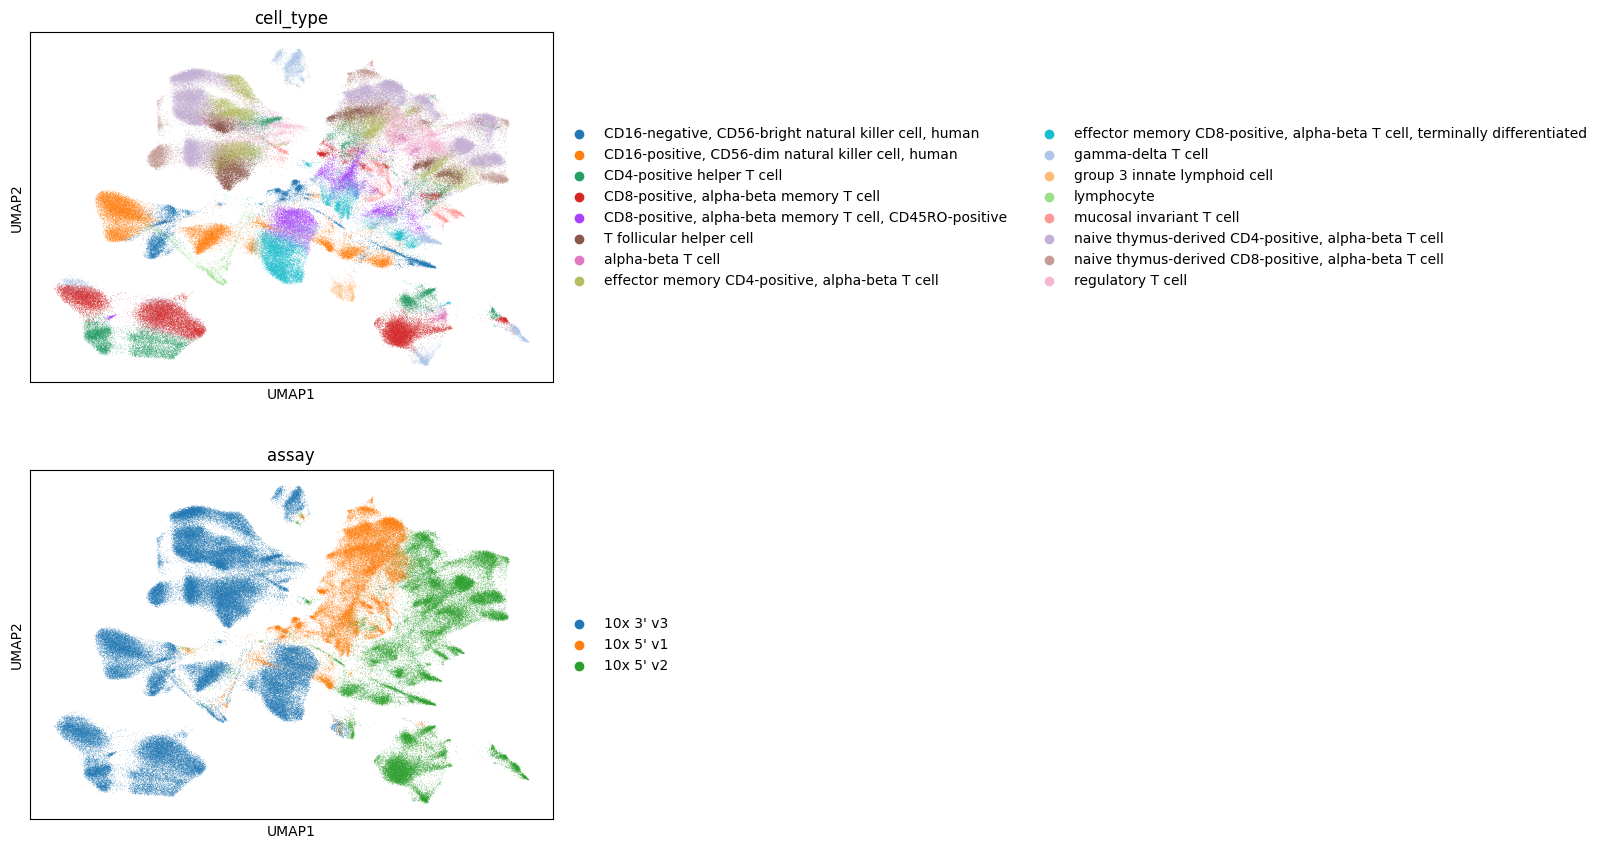

In [33]:
sc.pl.umap(adata, color=["cell_type", "assay"],ncols=1,)

### Batch Correction  

In the previous UMAP, we observed strong batch effects between assay types.  
To correct for this, we apply **Harmony**, a method that aligns different batches while preserving biological variation.  

After applying Harmony, we will redo:  
- **Neighborhood search** to recompute the k-nearest neighbor graph  
- **UMAP** to visualize the corrected embedding  
- **Graph-based clustering** to identify cell populations without batch-driven artifacts  

This ensures that batch effects do not drive clustering results while retaining meaningful biological structure.


In [34]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator

rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=True,  # default is False
    devices=0,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

In [35]:
%%time
rsc.pp.harmony_integrate(adata, key="assay", dtype=cp.float32)

CPU times: user 4.41 s, sys: 117 ms, total: 4.53 s
Wall time: 4.53 s


In [36]:
%%time
rsc.pp.neighbors(adata, n_neighbors=15, n_pcs=40,use_rep="X_pca_harmony",key_added="harmony")
rsc.tl.umap(adata,neighbors_key="harmony",key_added="X_umap_harmony")
rsc.tl.louvain(adata, resolution=0.6,neighbors_key="harmony",key_added="louvain_harmony")
rsc.tl.leiden(adata, resolution=0.6,neighbors_key="harmony",key_added="leiden_harmony")

CPU times: user 2.12 s, sys: 632 ms, total: 2.75 s
Wall time: 2.75 s


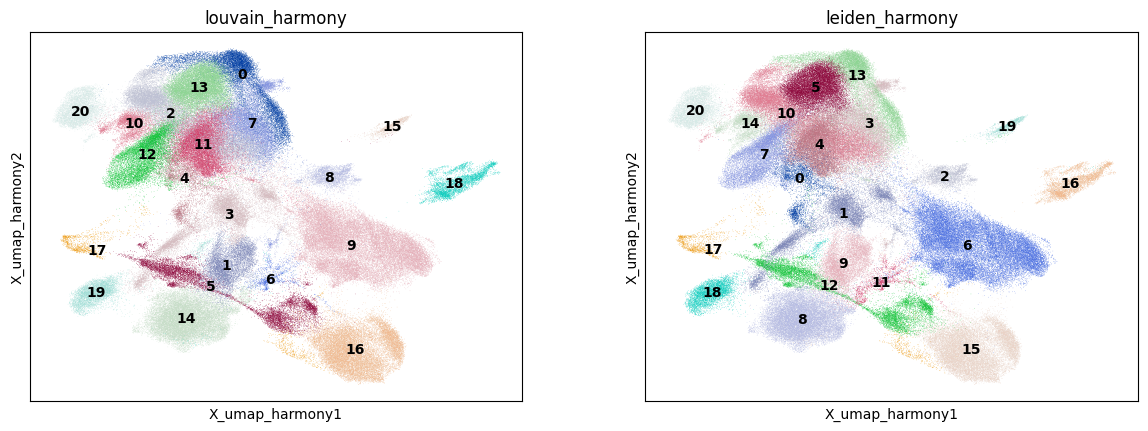

CPU times: user 1.38 s, sys: 12 ms, total: 1.39 s
Wall time: 1.39 s


In [37]:
%%time
sc.pl.embedding(adata,basis="X_umap_harmony", color=["louvain_harmony", "leiden_harmony"], legend_loc="on data")

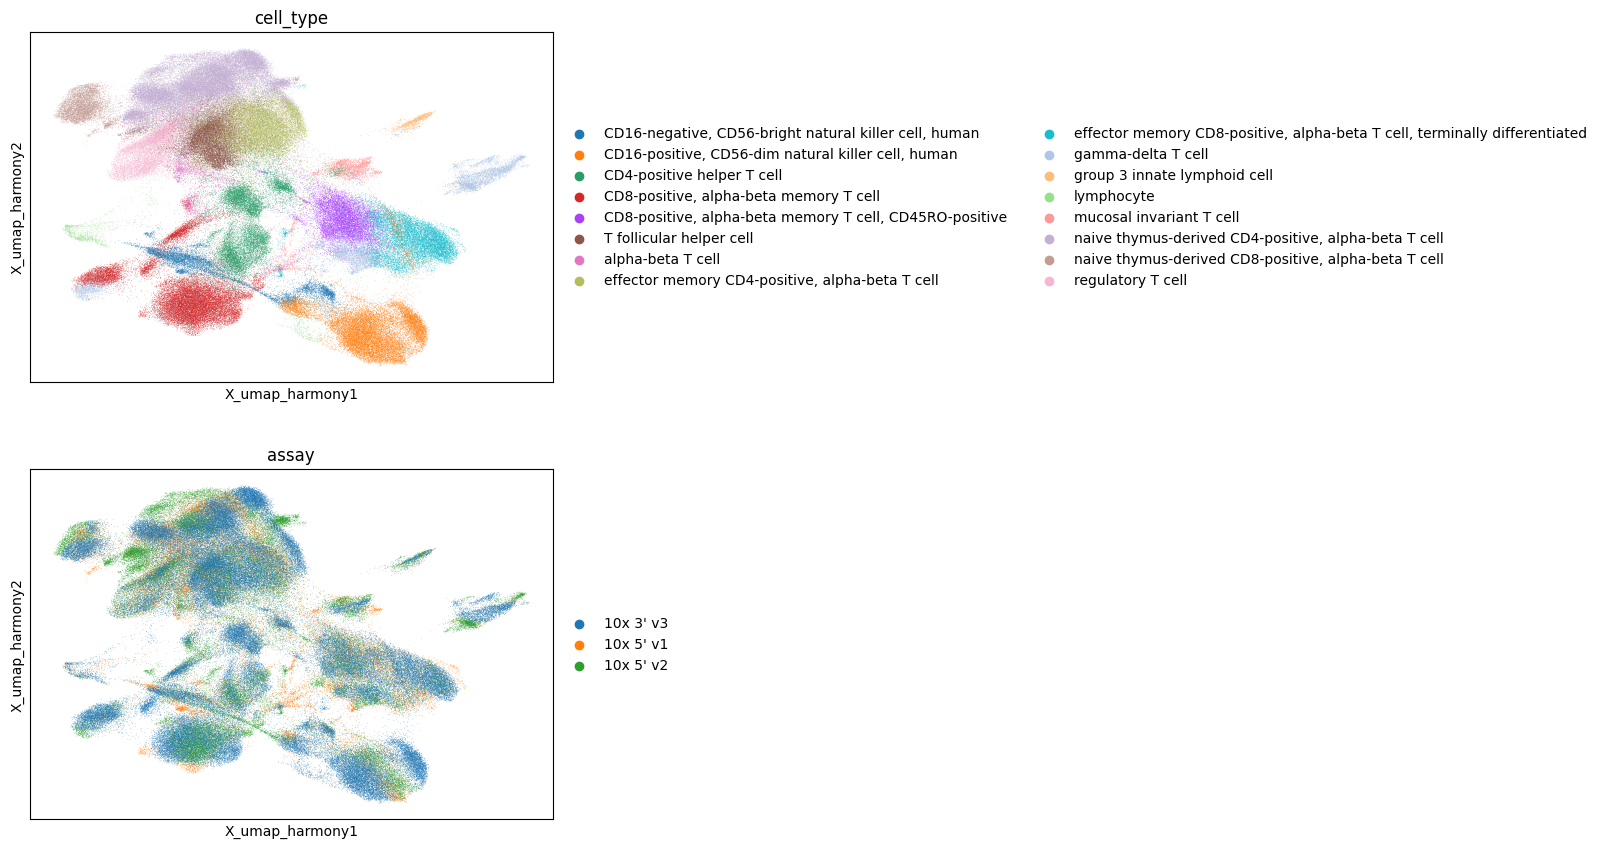

In [38]:
sc.pl.embedding(adata,basis="X_umap_harmony", color=["cell_type", "assay"], ncols=1)

### TSNE

Next, we use **t-distributed Stochastic Neighbor Embedding (t-SNE)** to visualize cells in two dimensions.  
t-SNE is a non-linear dimensionality reduction technique that preserves local structure and reveals complex patterns in the data.  

We leverage the RAPIDS GPU implementation of t-SNE, which is significantly faster than CPU-based methods.  
This allows us to efficiently process large datasets while maintaining high-quality embeddings.  



In [39]:
%%time
rsc.tl.tsne(adata, n_pcs=40, perplexity=30, early_exaggeration=12, learning_rate=200, use_rep="X_pca_harmony")

[W] [16:13:09.501768] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 2.31 s, sys: 2.29 s, total: 4.6 s
Wall time: 4.57 s


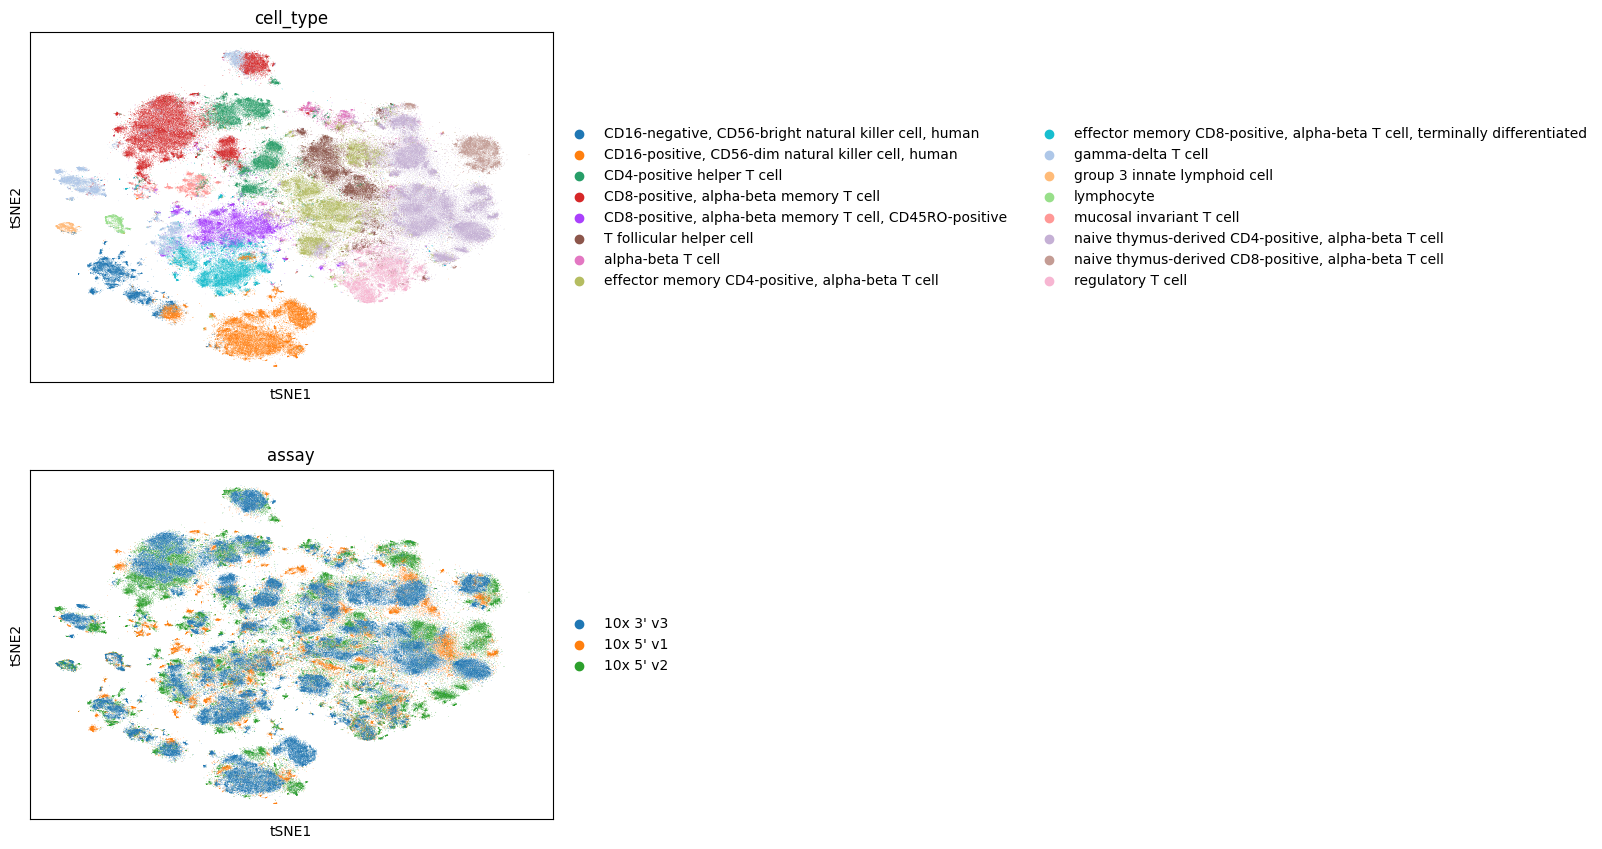

In [40]:
sc.pl.tsne(adata, color=["cell_type", "assay"], ncols=1)

## Differential expression analysis

To identify key marker genes for each cell type, we use **logistic regression** to compute a ranking of highly differential genes.  
Unlike traditional statistical tests, logistic regression models the probability of a gene being highly expressed in a given cluster  
while accounting for all genes simultaneously, making it more robust for complex datasets.  

We rank the top 50 genes that best distinguish each **cell type**, helping to characterize biological differences between clusters.  

In [41]:
%%time
rsc.tl.rank_genes_groups_logreg(adata, groupby="cell_type", use_raw=False)

[W] [16:13:33.249025] L-BFGS: max iterations reached
[W] [16:13:33.249241] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
CPU times: user 11.1 s, sys: 6.64 s, total: 17.7 s
Wall time: 17.7 s


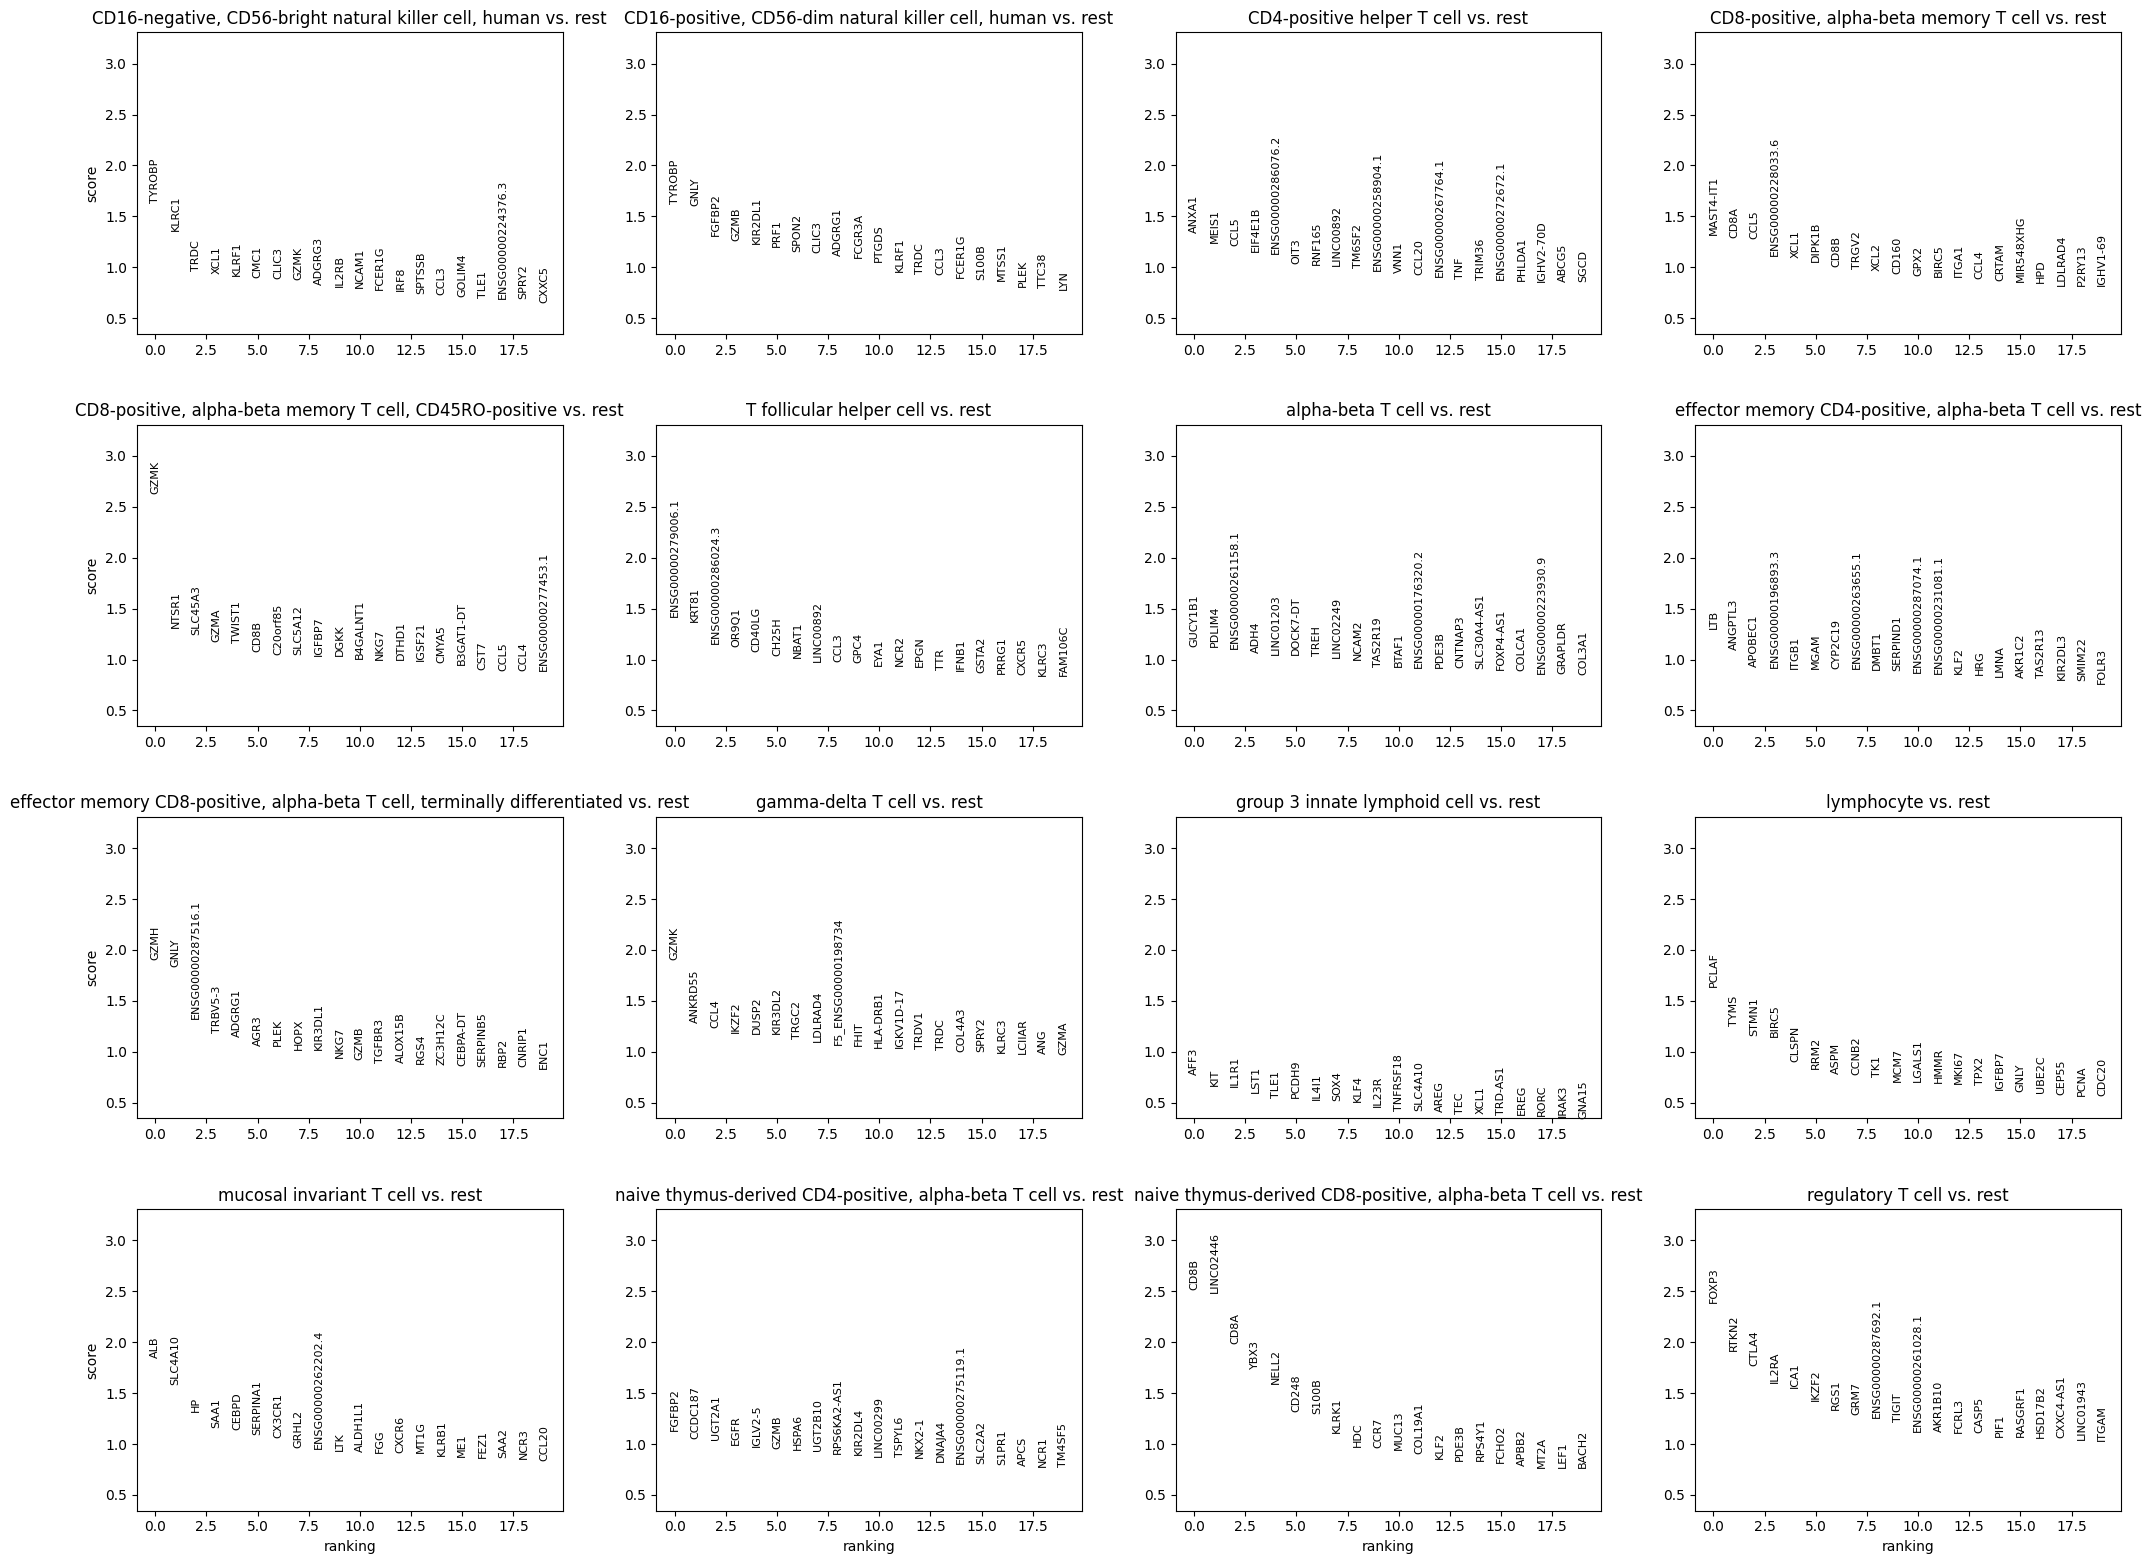

In [42]:
sc.pl.rank_genes_groups(adata)

In [43]:
post_time = time.time()

In [44]:
print("Total Postprocessing time: %s" % (post_time - preprocess_time))

Total Postprocessing time: 46.12144637107849


### Diffusion Map Embedding  

Next, we compute **Diffusion Maps**, a nonlinear dimensionality reduction method that preserves the continuous structure of the data.  
Unlike UMAP and t-SNE, Diffusion Maps are well-suited for capturing **trajectory-like** relationships in single-cell data.  

We use the batch-corrected neighborhood graph (`neighbors_key="harmony"`) to ensure that the embedding is not influenced by batch effects.  

In [45]:
%%time
rsc.tl.diffmap(adata,neighbors_key="harmony")
#Due to an issue with plotting in Scanpy, we need to shift the first component of the diffusion map by removing the first column:
adata.obsm["X_diffmap"] = adata.obsm["X_diffmap"][:, 1:]

CPU times: user 1.54 s, sys: 261 μs, total: 1.54 s
Wall time: 1.54 s


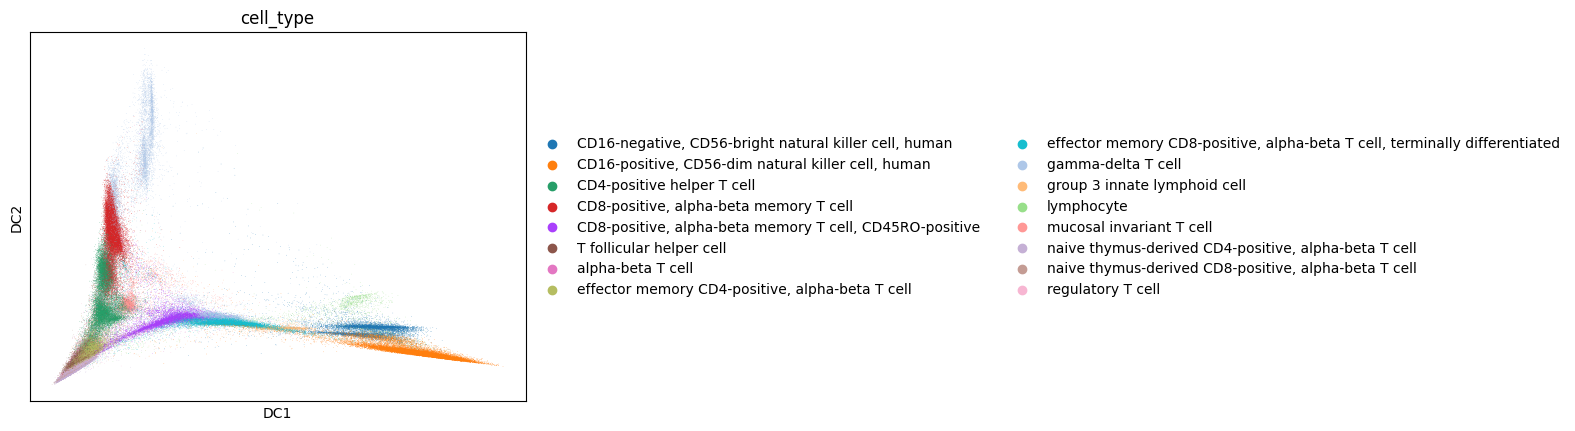

In [46]:
sc.pl.diffmap(adata, color="cell_type")

In [47]:
print("Total Processing time: %s" % (time.time() - preprocess_start))

Total Processing time: 57.584962129592896


In [48]:
adata.write("h5/dli_decoupler.h5ad")